In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [39]:
df = pd.read_csv('../datafiles/CO_2014_2015.csv')
df.shape

(139616, 45)

#### Assigning X and y

In [40]:
X = df[cols]
y = df['Pass_Winter_2015']

### Baseline for Previous Pass Customers purchasing a 2015/2016 Pass

In [41]:
df['Pass_Winter_2015'].mean()

0.4682128122851249

#### Mean of Winter 2015 passes based on if they had a 2014 Pass

In [42]:
df.groupby('Pass_Winter_2014')['Pass_Winter_2015'].mean()

Pass_Winter_2014
0    0.335668
1    0.631750
Name: Pass_Winter_2015, dtype: float64

#### Train, Test, Split of X and y

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [44]:
y_train.mean()

0.46732943693177476

In [45]:
y_test.mean()

0.47086293834517534

#### Scaling the data for some of the models

In [46]:
ss = StandardScaler()
# Fit Scaler on X_train data from TTS
ss.fit(X_train)
# Transform X_Train data from TTS
X_train_scaled = ss.transform(X_train)
#Transform X_test from TTS
X_test_scaled = ss.transform(X_test)

### XGBoost Model

In [47]:
# Fit model to training data.
#%%time
XGB = XGBClassifier()
XGB.fit(X_train, y_train)
print('Logreg Training CrossVal score:', cross_val_score(XGB, X_train, y_train).mean())
print('Logreg Testing score:', XGB.score(X_test,y_test))

/Users/craigstrong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/craigstrong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Logreg Training CrossVal score: 0.8126766801662845
Logreg Testing score: 0.81199862479945


/Users/craigstrong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/craigstrong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Code to plot importance of coefficients

In [48]:
def plot_importances(classifier, feature_names, top_features=10):
    coef = classifier.feature_importances_.ravel()
    top_importances = np.argsort(coef)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    plt.bar(np.arange(top_features), coef[top_importances], color='blue')
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(0, top_features),
        feature_names[top_importances],
        rotation=60, ha='right')

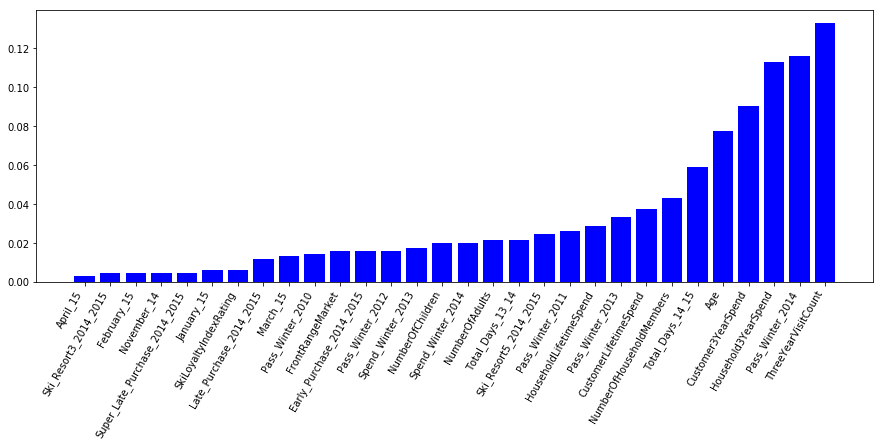

In [49]:
plot_importances(XGB,X.columns,30)

In [50]:
#XGB.plot_tree(xg_reg,num_trees=0)
#plt.rcParams['figure.figsize'] = [50, 10]
#plt.show()

In [51]:
predictions = XGB.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions) * 100.0))

Accuracy: 81.20%


/Users/craigstrong/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


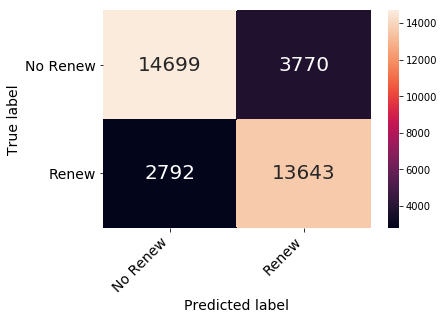

In [52]:
confusion_matrix_xgb = confusion_matrix(y_test, predictions)
confusion_matrix_df = pd.DataFrame(confusion_matrix_xgb, ('No Renew', 'Renew'), ('No Renew', 'Renew'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show();

In [53]:
predictions_proba = XGB.predict_proba(X_test)
df_XGB = pd.DataFrame(y_test)
df_XGB.loc[:, 'actual_y'] = y
df_XGB.loc[:, 'predicted_label'] = predictions
df_XGB.loc[:, 'predicted_proba'] = predictions_proba[:, 1]
df_XGB.head()

,Pass_Winter_2015,actual_y,predicted_label,predicted_proba
33735,1,1,0,0.409219
89699,0,0,0,0.094691
104196,1,1,1,0.733845
87504,0,0,0,0.197052
32690,1,1,1,0.591669


#### Plot  ROC/AUC Curve

/Users/craigstrong/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


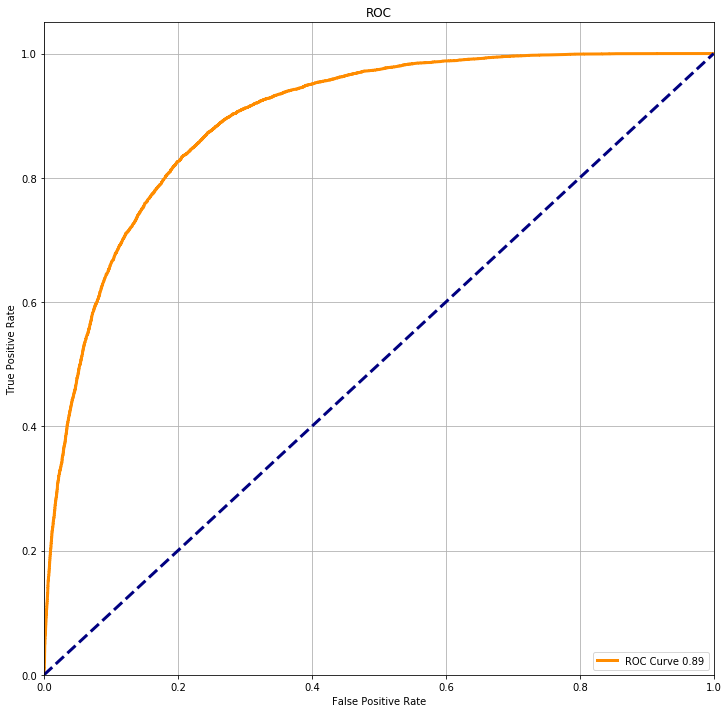

AUC: 0.8942906311092533


In [54]:
# Generate False positive rate and True positive rate
tpr, fpr, thresholds = roc_curve(y_test,df_XGB['predicted_proba'], pos_label=0)
roc_auc = auc(fpr, tpr)

# Plot 
plt.figure(figsize=(12,12))
line_width = 3
plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.grid("True")
plt.legend(loc="lower right")
plt.show()

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [55]:
def get_confusion_metric(row):    
    if row['actual_y'] == 1.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "True Positive"
    if row['actual_y'] == 1.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "False Negative"
    if row['actual_y'] == 0.0 and row['predicted_label'] == 0.0:
        row['confusion_metric'] = "True Negative"
    if row['actual_y'] == 0.0 and row['predicted_label'] == 1.0:
        row['confusion_metric'] = "False Positive"
    return row

#### Change Prediction based on a Threshold of .65 instead of the .5. We want to minimize False Positives.

In [56]:
#%%time
# Threshold of .65
df_XGB.loc[:,'predicted_label'] = df_XGB['predicted_proba'].map(lambda p: 1 if p > .65 else 0)
df_XGB.apply(get_confusion_metric, axis = 1)['confusion_metric'].value_counts().sort_index()

False Negative     5606
False Positive     1825
True Negative     16644
True Positive     10829
Name: confusion_metric, dtype: int64

#### Create a column that says if the prediction was incorrect for analysis in Tableau

In [57]:
df_XGB = df_XGB[['actual_y', 'predicted_label','predicted_proba']].assign(not_equal=df_XGB.actual_y != df_XGB.predicted_label)

#### Merge the test predictions with the features for analysis in Tableau

In [58]:
# Join id to X_TEST where INDEXES are equal
df_xgb_out = pd.merge(df, df_XGB, left_index=True, right_index=True)

In [59]:
df_XGB.shape

(34904, 4)

In [60]:
df_xgb_out.shape

(34904, 49)

In [61]:
pd.DataFrame(df_xgb_out).to_csv('../datafiles/CO_2015_2016_XGB.csv', index=False)